In [41]:
import pandas as pd
import numpy as np
import pickle

In [42]:
intraday = True
timeframe = 5
symbol = 'ITUB4'

if intraday:
    csv_path = f'dados/{symbol}_intraday_mt5timeframe_{timeframe}.csv'
else:
    csv_path = f'dados/{symbol}_daily.csv'

In [43]:
raw = pd.read_csv(csv_path, index_col=['datetime'], parse_dates=True).dropna()

In [44]:
raw

,time,open,high,low,close,tick_volume,spread,real_volume
datetime,,,,,,,,
2017-04-26 12:10:00,1493208600,24.17,24.19,24.15,24.15,191,1,40000
2017-04-26 12:15:00,1493208900,24.15,24.19,24.14,24.18,178,1,56200
2017-04-26 12:20:00,1493209200,24.17,24.19,24.17,24.19,225,1,115700
2017-04-26 12:25:00,1493209500,24.19,24.23,24.19,24.22,378,1,147300
2017-04-26 12:30:00,1493209800,24.20,24.22,24.19,24.22,109,1,32400
...,...,...,...,...,...,...,...,...
2021-10-19 17:35:00,1634664900,24.39,24.42,24.36,24.42,23,1,13600
2021-10-19 17:40:00,1634665200,24.40,24.44,24.40,24.42,19,1,15500
2021-10-19 17:45:00,1634665500,24.44,24.45,24.36,24.36,30,1,10500


In [45]:
raw = pd.DataFrame(raw[['open', 'high', 'low', 'close', 'real_volume']])
raw.rename(columns={'real_volume': 'volume'}, inplace=True)

In [46]:
raw

,open,high,low,close,volume
datetime,,,,,
2017-04-26 12:10:00,24.17,24.19,24.15,24.15,40000
2017-04-26 12:15:00,24.15,24.19,24.14,24.18,56200
2017-04-26 12:20:00,24.17,24.19,24.17,24.19,115700
2017-04-26 12:25:00,24.19,24.23,24.19,24.22,147300
2017-04-26 12:30:00,24.20,24.22,24.19,24.22,32400
...,...,...,...,...,...
2021-10-19 17:35:00,24.39,24.42,24.36,24.42,13600
2021-10-19 17:40:00,24.40,24.44,24.40,24.42,15500
2021-10-19 17:45:00,24.44,24.45,24.36,24.36,10500


In [47]:
mean = raw['close'].mean()

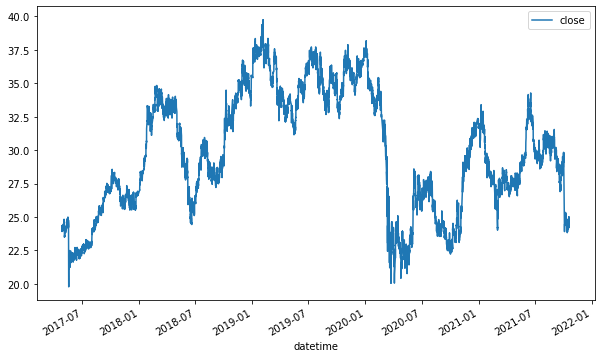

In [48]:
raw['close'].plot(figsize=(10, 6), legend=True);

In [49]:
data = pd.DataFrame(raw['close'])

In [50]:
window = 5
data['return'] = np.log(data / data.shift(1))
data['vol'] = data['return'].rolling(window).std()
data['mom'] = np.sign(data['return'].rolling(window).mean())
data['sma'] = data['close'].rolling(window).mean()
data['min'] = data['close'].rolling(window).min()
data['max'] = data['close'].rolling(window).max()

In [51]:
data.dropna(inplace = True)

In [52]:
lags = 3

In [53]:
features = ['return', 'vol', 'mom', 'sma', 'min', 'max']

In [54]:
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        data[col] = data[f].shift(lag)
        cols.append(col)

In [ ]:
cols

In [55]:
data.dropna(inplace = True)

In [56]:
data['direction'] = np.where(data['return'] > 0, 1, -1)

In [57]:
data[cols].iloc[:lags, :lags]

,return_lag_1,return_lag_2,return_lag_3
datetime,,,
2017-04-26 12:50:00,-0.002486,-0.000827,-0.001239
2017-04-26 12:55:00,0.000000,-0.002486,-0.000827
2017-04-26 13:00:00,0.000000,0.000000,-0.002486


In [58]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [59]:
n_estimators = 15
random_state = 100
max_depth = 2
min_samples_leaf = 15
subsample = 0.33

In [60]:
dtc = DecisionTreeClassifier(random_state = random_state,
                            max_depth = max_depth,
                            min_samples_leaf = min_samples_leaf)

In [61]:
model = AdaBoostClassifier(base_estimator = dtc,
                          n_estimators = n_estimators,
                          random_state = random_state)

In [62]:
split = int(len(data) * 0.7)

In [63]:
train = data.iloc[:split].copy()

In [64]:
mu, std = train.mean(), train.std()

In [65]:
train_ = (train - mu) / std

In [66]:
model.fit(train_[cols], train['direction'])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=15,
                                                         random_state=100),
                   n_estimators=15, random_state=100)

In [67]:
accuracy_score(train['direction'], model.predict(train_[cols]))

0.5680596250675618

In [68]:
test = data.iloc[split:].copy()

In [69]:
test_ = (test - mu) / std

In [70]:
test['position'] = model.predict(test_[cols])

In [71]:
accuracy_score(test['direction'], test['position'])

0.5516726403823178

In [72]:
test['strategy'] = test['position'] * test['return']

In [73]:
sum(test['position'].diff() != 0)

4815

In [74]:
test[['return', 'strategy']].sum().apply(np.exp)

return      0.935819
strategy    4.120085
dtype: float64

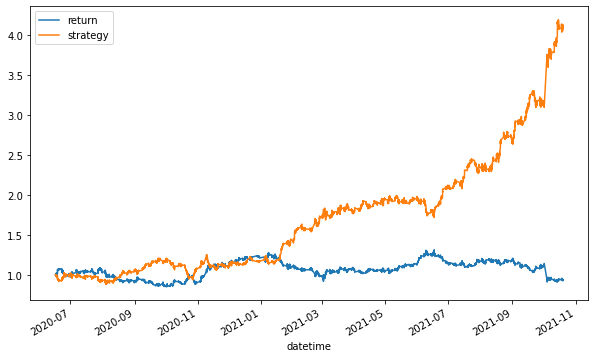

In [75]:
test[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [78]:
algorithm = {'model': model, 'mu': mu, 'std': std}

In [79]:
pickle.dump(algorithm, open('models/algorithm.pkl', 'wb'))